In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
import os
import matplotlib as mpl
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from experiments.configs.regression_consts import VALID_UQ_METHODS, VALID_ESTIMATORS, MODELS, DATASETS, SINGLE_CONFORMAL_METHODS
plt.rcParams['text.usetex'] = True
plt.rcParams.update({
    "text.usetex": True,              # Use TeX for text rendering
    "font.family": "serif",
    "hatch.color": "white"
})
%load_ext autoreload
%autoreload 2

# Load Results

In [2]:
train_size = 0.8
aggregated_sg_results = pickle.load(open(f'../results/regression/aggregated_results/all_subgroup_results_train_size_{train_size}.pkl', 'rb'))

In [3]:
train_size = 0.8
aggregated_results = pickle.load(open(f'../results/regression/aggregated_results/all_results_train_size_{train_size}.pkl', 'rb'))

In [4]:
def convert_results_to_df(results_dict):
   
    df = pd.DataFrame.from_dict(
        {(dataset, method, hyperparam): metrics
        for dataset, methods in results_dict.items()
        for (method, hyperparam), metrics in methods.items()},
        orient='index'
    )

    # Convert index into MultiIndex
    df.index = pd.MultiIndex.from_tuples(df.index, names=['Dataset', 'Method', 'Estimator'])

    # Reset index to move 'Dataset' to a normal column
    df = df.reset_index()

    # Pivot table to reshape
    df = df.pivot(index="Dataset", columns=["Method", "Estimator"])

    # Fix column ordering
    df.columns = df.columns.reorder_levels([1, 2, 0])  # Move metric to last level
    df = df.sort_index(axis=1)  # Sort for readability
    return df

In [30]:
df = convert_results_to_df(aggregated_results)
df = df.loc[:, (['pcs_oob', 'pcs_uq'], slice(None), ['coverage_mean', 'mean_width_scaled_mean'])]
df = df.sort_values(by = ('pcs_oob','', 'mean_width_scaled_mean'), ascending=True)

In [31]:
print(df.to_latex(index=True, float_format="%.3f"))

\begin{tabular}{lrrrr}
\toprule
Method & \multicolumn{2}{r}{pcs_oob} & \multicolumn{2}{r}{pcs_uq} \\
Estimator & \multicolumn{2}{r}{} & \multicolumn{2}{r}{} \\
 & coverage_mean & mean_width_scaled_mean & coverage_mean & mean_width_scaled_mean \\
Dataset &  &  &  &  \\
\midrule
data_naval_propulsion & 0.906 & 0.001 & 0.906 & 0.001 \\
data_energy_efficiency & 0.919 & 0.030 & 0.918 & 0.035 \\
data_computer & 0.899 & 0.066 & 0.898 & 0.067 \\
data_miami_housing & 0.904 & 0.076 & 0.901 & 0.080 \\
data_diamond & 0.902 & 0.093 & 0.900 & 0.094 \\
data_insurance & 0.907 & 0.127 & 0.912 & 0.179 \\
data_elevator & 0.901 & 0.127 & 0.903 & 0.133 \\
data_airfoil & 0.922 & 0.134 & 0.907 & 0.159 \\
data_powerplant & 0.904 & 0.139 & 0.905 & 0.147 \\
data_concrete & 0.915 & 0.172 & 0.917 & 0.209 \\
data_debutanizer & 0.907 & 0.187 & 0.901 & 0.206 \\
data_superconductor & 0.902 & 0.193 & 0.898 & 0.221 \\
data_parkinsons & 0.904 & 0.201 & 0.898 & 0.206 \\
data_ca_housing & 0.903 & 0.271 & 0.898 & 0.275 \\


# Plot Widths (Version 1)

In [ ]:
colors_dict = {'pcs_oob': 'orange', 'split_conformal': '#B2746B', 'studentized_conformal': '#697fa0', 'majority_vote': '#86a76c'}
markers_dict = {'pcs_oob': 'X', 'split_conformal': 'o', 'studentized_conformal': '^', 'majority_vote': 's'}
colors_dict_formal = {'PCS': 'orange', 'Split Conformal (XGBoost)': '#B2746B', 'Studentized Conformal (Random Forest)': '#697fa0', 'Majority Vote': '#86a76c'}
markers_dict_formal = {'PCS': 'X', 'Split Conformal (XGBoost)': 'o', 'Studentized Conformal (Random Forest)': '^', 'Majority Vote': 's'}

In [ ]:
def make_subgroup_plot(dataset, sg_feature, group_list, save_path=None, xlims=[0,1], ylims=[0, 1], sg_select=None):
    # pull dataset
    # get subgroup metrics
    sg_results_dict = {}
    sg_df_dict = aggregated_sg_results[dataset]
    for sg_group, sg_metrics in sg_df_dict[('studentized_conformal', 'RandomForest')][sg_feature].items():
        sg_results_dict[('studentized_conformal', 'RandomForest', sg_group)] = sg_metrics

    for sg_group, sg_metrics in sg_df_dict[('split_conformal', 'XGBoost')][sg_feature].items():
        sg_results_dict[('split_conformal', 'XGBoost', sg_group)] = sg_metrics

    for sg_group, sg_metrics in sg_df_dict[('majority_vote', '')][sg_feature].items():
        sg_results_dict[('majority_vote', '', sg_group)] = sg_metrics

    for sg_group, sg_metrics in sg_df_dict[('pcs_oob','')][sg_feature].items():
        sg_results_dict[('pcs_oob','', sg_group)] = sg_metrics
    sg_df = pd.DataFrame.from_dict(sg_results_dict, orient='index')
    sg_df.index = pd.MultiIndex.from_tuples(sg_df.index, names=['Method', 'Estimator', 'SG_Group'])
    sg_df = sg_df.reset_index()

    # get overall metrics
    results_dict = {}
    df_dict = aggregated_results[dataset]
    results_dict[('studentized_conformal', 'RandomForest')] = df_dict[('studentized_conformal', 'RandomForest')]
    results_dict[('split_conformal', 'XGBoost')] = df_dict[('split_conformal', 'XGBoost')]
    results_dict[('majority_vote', '')] = df_dict[('majority_vote', '')]
    results_dict[('pcs_oob','')] = df_dict[('pcs_oob','')]
    df = pd.DataFrame.from_dict(results_dict, orient='index')
    df.index = pd.MultiIndex.from_tuples(df.index, names=['Method', 'Estimator'])
    df = df.reset_index()

    # make plot
    sns.set_context("paper", font_scale=1.5)
    fig, axes = plt.subplot_mosaic([['ova', 'sg1'], ['ova', 'sg2']], figsize=(9, 4), width_ratios=[0.9, 0.8])

    sns.scatterplot(data=df, x='mean_width_scaled_mean', y='coverage_mean',
                    hue='Method', style='Method', ax=axes['ova'],
                    palette=colors_dict, markers=markers_dict,
                    legend=True, s=500)
    axes['ova'].set_title(r'\textbf{' + '(A) Overall}', loc='center', fontsize=14, fontweight='black')

    handles = []
    unique_methods = colors_dict_formal.keys()
    for method in unique_methods:
        handles.append(plt.Line2D([0], [0], marker=markers_dict_formal[method], color=colors_dict_formal[method], label=method, markersize=12, linestyle='None'))

    legend_labels = unique_methods
    axes['ova'].legend(handles, legend_labels, title="", loc='lower left' ,title_fontsize='small', labelspacing=0.2, fontsize=12)

    if sg_select is not None:
        sg_groups = sg_df['SG_Group'].unique()[sg_select]
    else:
        if len(sg_df['SG_Group'].unique()) != 2:
            raise ValueError('Subgroup plot only supports 2 subgroups')
        else:
            sg_groups = sg_df['SG_Group'].unique()
        
    i = 1
    for sg in sg_groups:
        sg_plot = sg_df[sg_df['SG_Group'] == sg]
        legend = False
        sns.scatterplot(data=sg_plot, x='mean_width_scaled_mean', y='coverage_mean',
                        hue='Method', style='Method', ax=axes[f'sg{i}'],
                        palette=colors_dict, markers=markers_dict,
                        legend=legend, s=500)
        axes[f'sg{i}'].set_title(r'\textbf{' + group_list[i-1] + '}', loc='center', fontsize=14, fontweight='black')
        i += 1

        for ax in axes.values():
            ax.set_xlim(xlims[0], xlims[1])
            ax.set_ylim(ylims[0], ylims[1])
            #ax.set_yticks(np.arange(0.7, 1.05, 0.1))
            ax.axhline(0.9, linestyle='dashed', color='black')
            ax.set_ylabel('Coverage', fontsize=14)
            ax.set_xlabel('Mean Width', fontsize=14)
            ax.grid(True, linestyle='--', alpha=0.6)   

    fig.tight_layout(pad=0.3)
    if save_path is not None:
        fig.savefig(save_path, bbox_inches='tight')
    fig.show()

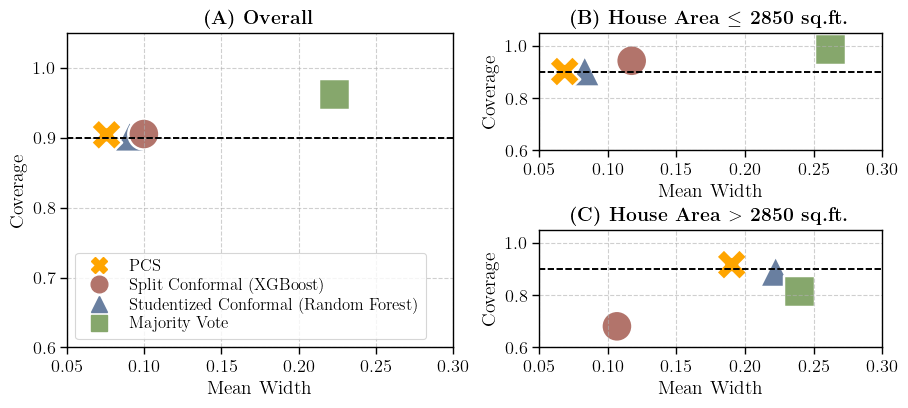

In [158]:
sgs = [r'(B) House Area $\leq$ 2850 sq.ft.', r'(C) House Area $>$ 2850 sq.ft.']
make_subgroup_plot('data_miami_housing', 'TOT_LVG_AREA', sgs, xlims=[0.05, 0.3], ylims=[0.6, 1.05],
                   save_path='figures/subgroup_miami.pdf')

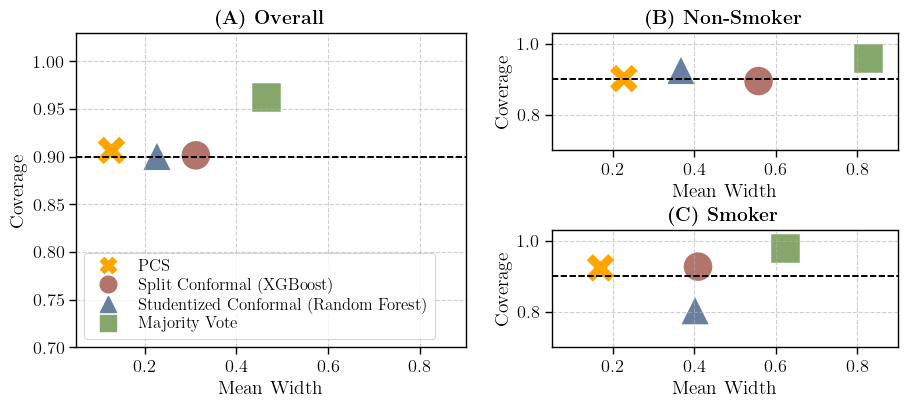

In [139]:
sgs = [r'(B) Non-Smoker', r'(C) Smoker']
make_subgroup_plot('data_insurance', 'smoker_yes', sgs, xlims=[0.05,0.9], ylims=[0.7, 1.03],
                   save_path='figures/subgroup_insurance.pdf')

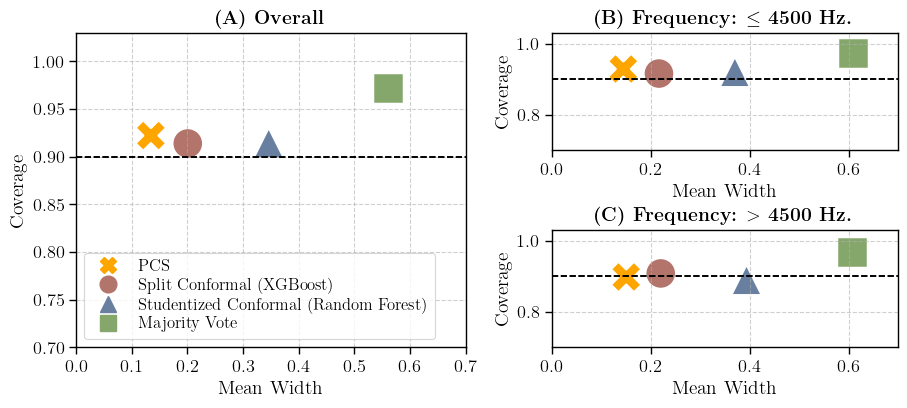

In [140]:
sgs = [r'(B) Frequency: $\leq$ 4500 Hz.', r'(C) Frequency: $>$ 4500 Hz.']
make_subgroup_plot('data_airfoil', 'frequency', sgs, xlims=[0, 0.7], ylims=[0.7, 1.03],
                   save_path='figures/subgroup_airfoil.pdf')

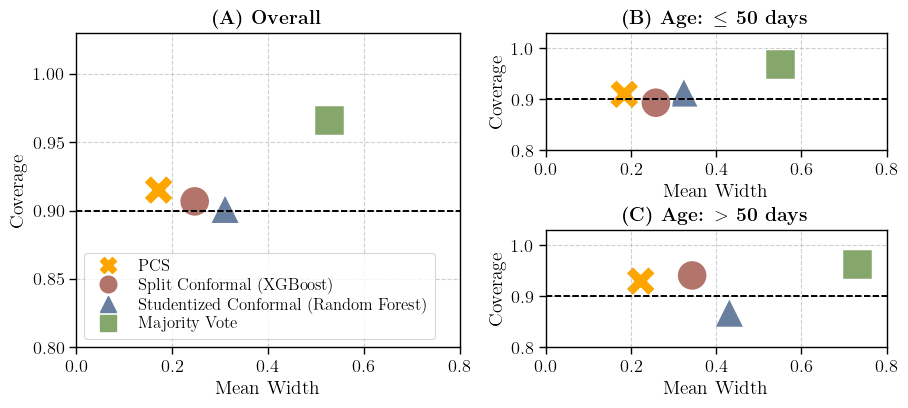

In [141]:
sgs = [r'(B) Age: $\leq$ 50 days', r'(C) Age: $>$ 50 days']
make_subgroup_plot('data_concrete', 'Age', sgs,
                    xlims=[0, 0.8], ylims=[0.8, 1.03],
                    save_path='figures/subgroup_concrete.pdf')

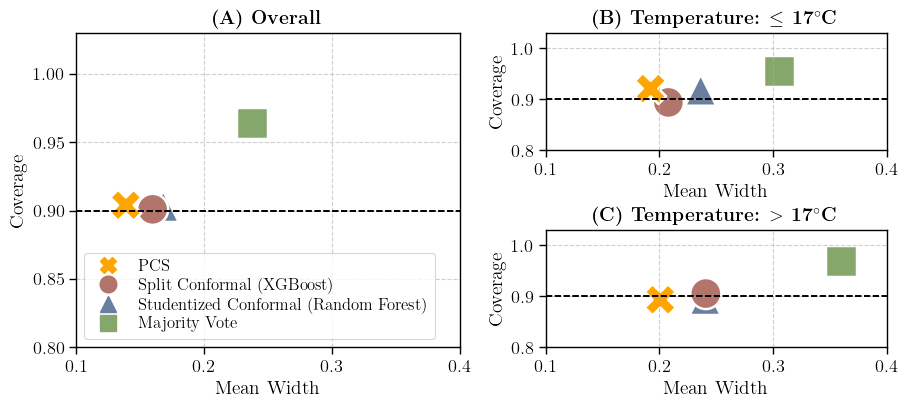

In [142]:
sgs = [r'(B) Temperature: $\leq$ 17$^\circ$C', r'(C) Temperature: $>$ 17$^\circ$C']
make_subgroup_plot('data_powerplant', 'AT', sgs,
                    xlims=[0.1, 0.4], ylims=[0.8, 1.03],
                    save_path='figures/subgroup_powerplant.pdf')

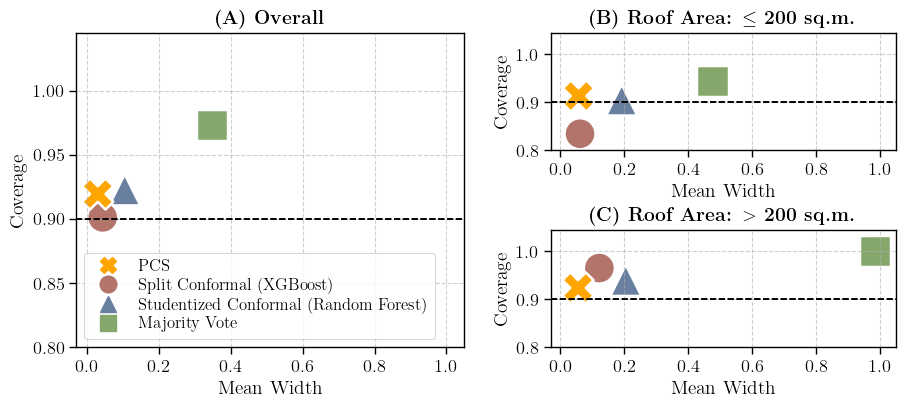

In [143]:
sgs = [r'(B) Roof Area: $\leq$ 200 sq.m.', r'(C) Roof Area: $>$ 200 sq.m.']
make_subgroup_plot('data_energy_efficiency', 'Roof_Area', sgs, xlims=[-0.03, 1.05], ylims=[0.8, 1.045],
                   save_path='figures/subgroup_energy_efficiency.pdf')

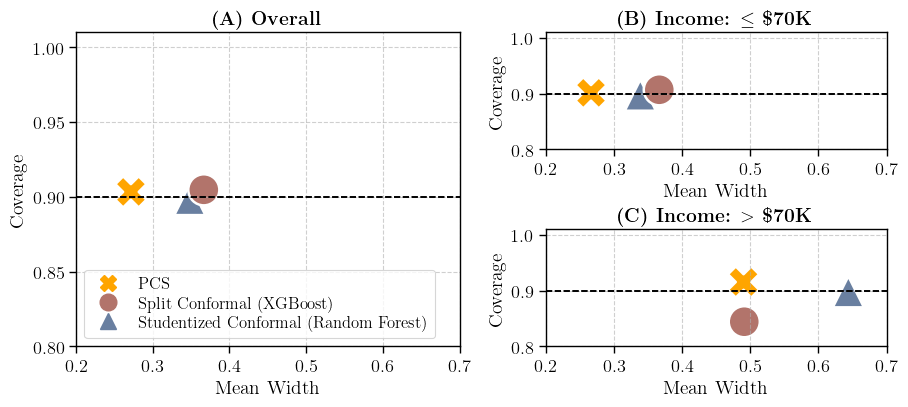

In [24]:
sgs = [r'(B) Income: $\leq$ \$70K', r'(C) Income: $>$ \$70K']
make_subgroup_plot('data_ca_housing', 'med_income', sgs, xlims=[0.2,0.7], ylims=[0.8,1.01], sg_select=[0,1],
                   save_path='figures/subgroup_ca.pdf')

# Plot Widths (Version 2)

In [20]:
colors_dict = {'pcs_oob': 'orange', 'split_conformal': '#B2746B', 'studentized_conformal': '#697fa0', 'majority_vote': '#86a76c'}
markers_dict = {'pcs_oob': 'X', 'split_conformal': 'o', 'studentized_conformal': '^', 'majority_vote': 's'}
colors_dict_formal = {'PCS': 'orange', 'Split Conformal (XGBoost)': '#B2746B', 'Studentized Conformal (Random Forest)': '#697fa0', 'Majority Vote': '#86a76c'}
markers_dict_formal = {'PCS': 'X', 'Split Conformal (XGBoost)': 'o', 'Studentized Conformal (Random Forest)': '^', 'Majority Vote': 's'}
informal_to_formal = {'pcs_oob': 'PCS', 'split_conformal': 'Split Conformal (XGBoost)', 'studentized_conformal': 'Studentized Conformal (Random Forest)', 'majority_vote': 'Majority Vote'}

In [28]:
def make_subgroup_plot_v2(dataset, sg_feature, group_list, methods, save_path=None, xlims=[0,1], ylims=[0, 1], sg_select=None):
    # pull dataset
    # get subgroup metrics
    sg_results_dict = {}
    sg_df_dict = aggregated_sg_results[dataset]
    for method in methods:
        for sg_group, sg_metrics in sg_df_dict[method][sg_feature].items():
            sg_results_dict[(method[0], method[1], sg_group)] = sg_metrics

    sg_df = pd.DataFrame.from_dict(sg_results_dict, orient='index')
    sg_df.index = pd.MultiIndex.from_tuples(sg_df.index, names=['Method', 'Estimator', 'SG_Group'])
    sg_df = sg_df.reset_index()

    # get overall metrics
    results_dict = {}
    df_dict = aggregated_results[dataset]
    for method in methods:
        results_dict[method] = df_dict[method]
    df = pd.DataFrame.from_dict(results_dict, orient='index')
    df.index = pd.MultiIndex.from_tuples(df.index, names=['Method', 'Estimator'])
    df = df.reset_index()

    # make plot
    sns.set_context("paper", font_scale=1.5)
    fig, axes = plt.subplot_mosaic([['ova', 'sg1'], ['ova', 'sg2']], figsize=(9, 4), width_ratios=[0.9, 0.8])

    sns.scatterplot(data=df, x='mean_width_scaled_mean', y='coverage_mean',
                    hue='Method', style='Method', ax=axes['ova'],
                    palette=colors_dict, markers=markers_dict,
                    legend=False, s=500)
    axes['ova'].set_title(r'\textbf{' + '(A) Overall}', loc='center', fontsize=14, fontweight='black')

    # make legend
    handles = []
    unique_methods = [informal_to_formal[method[0]] for method in methods]
    for method in unique_methods:
        handles.append(plt.Line2D([0], [0], marker=markers_dict_formal[method], color=colors_dict_formal[method], label=method, markersize=12, linestyle='None'))

    legend_labels = unique_methods
    fig.legend(handles, legend_labels, title="", loc='lower center', 
                title_fontsize='small', columnspacing=0.5, fontsize=14, 
                ncol=len(unique_methods), bbox_to_anchor=(0.52, -0.14), # -0.14, 1.15
                handletextpad=0.05, borderaxespad=0.3, frameon=False)

    # if multiple subgroups, take only the two in the sg_select list
    if sg_select is not None:
        sg_groups = sg_df['SG_Group'].unique()[sg_select]
    else:
        if len(sg_df['SG_Group'].unique()) != 2:
            raise ValueError('Subgroup plot only supports 2 subgroups')
        else:
            sg_groups = sg_df['SG_Group'].unique()
        
    i = 1
    for sg in sg_groups:
        sg_plot = sg_df[sg_df['SG_Group'] == sg]
        legend = False
        sns.scatterplot(data=sg_plot, x='mean_width_scaled_mean', y='coverage_mean',
                        hue='Method', style='Method', ax=axes[f'sg{i}'],
                        palette=colors_dict, markers=markers_dict,
                        legend=legend, s=500)
        axes[f'sg{i}'].set_title(r'\textbf{' + group_list[i-1] + '}', loc='center', fontsize=14, fontweight='black')
        i += 1

        for ax in axes.values():
            ax.set_xlim(xlims[0], xlims[1])
            ax.set_ylim(ylims[0], ylims[1])
            #ax.set_yticks(np.arange(0.7, 1.05, 0.1))
            ax.axhline(0.9, linestyle='dashed', color='black')
            ax.set_ylabel('Coverage', fontsize=14)
            ax.set_xlabel('Mean Width', fontsize=14)
            ax.grid(True, linestyle='--', alpha=0.6)   

    fig.tight_layout(pad=0.3)
    if save_path is not None:
        fig.savefig(save_path, bbox_inches='tight')
    fig.show()

In [32]:
selected_methods = [('studentized_conformal', 'RandomForest'), ('split_conformal', 'XGBoost'), ('majority_vote', ''), ('pcs_oob','')]

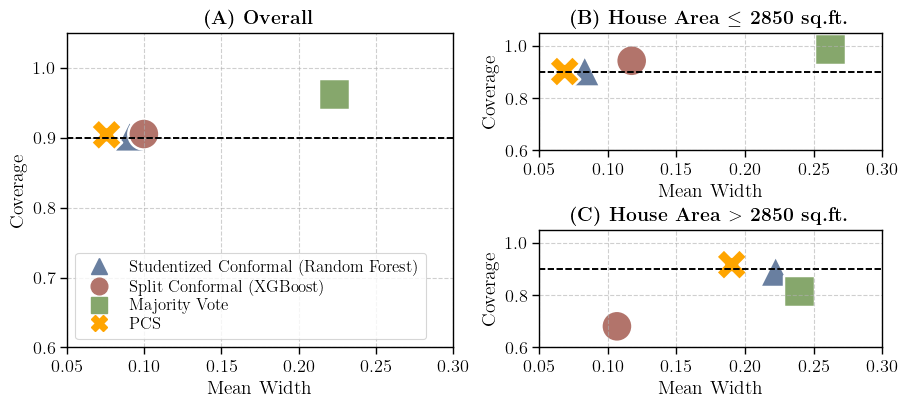

In [13]:
sgs = [r'(B) House Area $\leq$ 2850 sq.ft.', r'(C) House Area $>$ 2850 sq.ft.']
make_subgroup_plot_v2('data_miami_housing', 'TOT_LVG_AREA', sgs, selected_methods,
                      xlims=[0.05, 0.3], ylims=[0.6, 1.05],
                      save_path=None)

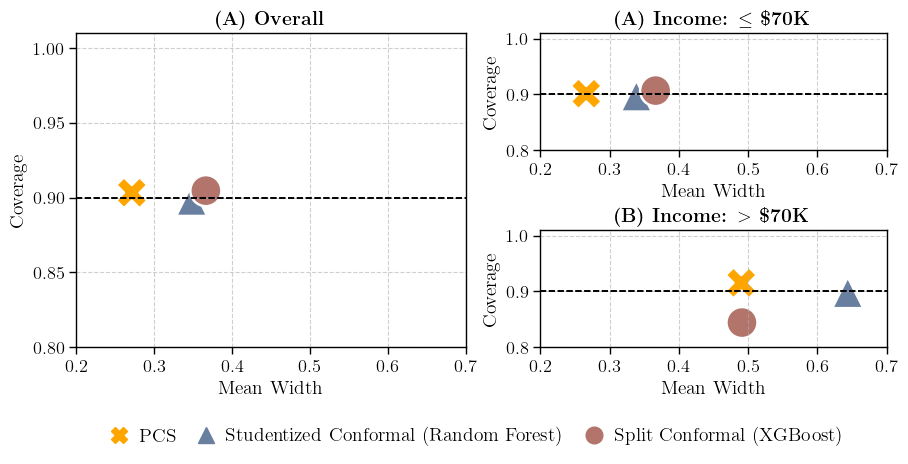

In [30]:
selected_methods = [('pcs_oob',''), ('studentized_conformal', 'RandomForest'), ('split_conformal', 'XGBoost'), ]
sgs = [r'(A) Income: $\leq$ \$70K', r'(B) Income: $>$ \$70K']
make_subgroup_plot_v2('data_ca_housing', 'med_income', sgs, selected_methods,
                   xlims=[0.2,0.7], ylims=[0.8,1.01], sg_select=[0,1],
                   save_path='figures/subgroup_ca_v2.png')

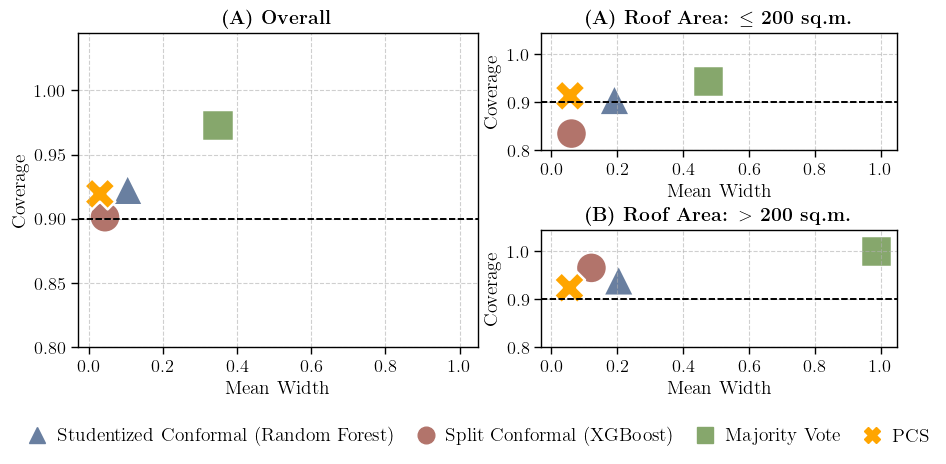

In [33]:
sgs = [r'(A) Roof Area: $\leq$ 200 sq.m.', r'(B) Roof Area: $>$ 200 sq.m.']
make_subgroup_plot_v2('data_energy_efficiency', 'Roof_Area', sgs, selected_methods,
                   xlims=[-0.03, 1.05], ylims=[0.8, 1.045],
                   save_path='figures/subgroup_energy_efficiency_v2.pdf')

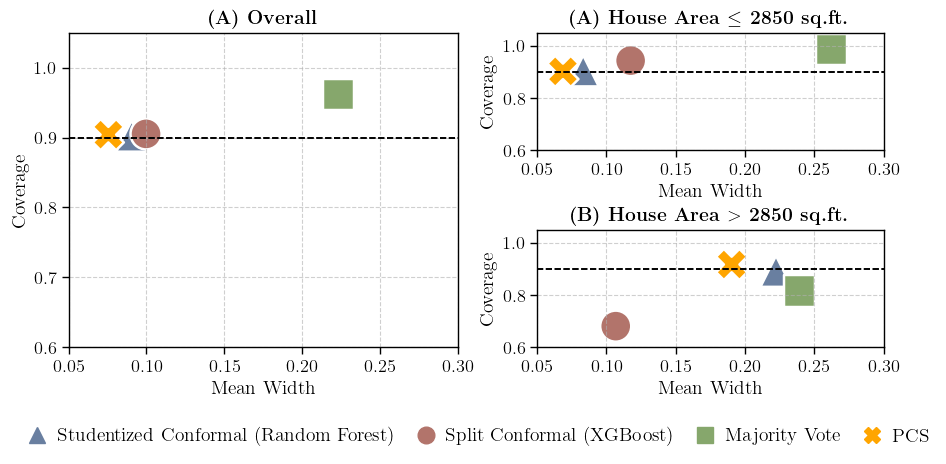

In [34]:
sgs = [r'(A) House Area $\leq$ 2850 sq.ft.', r'(B) House Area $>$ 2850 sq.ft.']
make_subgroup_plot_v2('data_miami_housing', 'TOT_LVG_AREA', sgs, selected_methods,
                      xlims=[0.05, 0.3], ylims=[0.6, 1.05],
                      save_path='figures/subgroup_miami_v2.pdf')

# Plot Widths (Version 3)

In [5]:
colors_dict = {'pcs_oob': 'orange', 'split_conformal': '#B2746B', 'studentized_conformal': '#697fa0', 'majority_vote': '#86a76c'}
markers_dict = {'pcs_oob': 'X', 'split_conformal': 'o', 'studentized_conformal': '^', 'majority_vote': 's'}
colors_dict_formal = {'PCS': 'orange', 'Split Conformal (XGBoost)': '#B2746B', 'Studentized Conformal (Random Forest)': '#697fa0', 'Majority Vote': '#86a76c'}
markers_dict_formal = {'PCS': 'X', 'Split Conformal (XGBoost)': 'o', 'Studentized Conformal (Random Forest)': '^', 'Majority Vote': 's'}
informal_to_formal = {'pcs_oob': 'PCS', 'split_conformal': 'Split Conformal (XGBoost)', 'studentized_conformal': 'Studentized Conformal (Random Forest)', 'majority_vote': 'Majority Vote'}

In [9]:
def make_subgroup_plot_v3(dataset, sg_feature, group_list, methods, save_path=None, xlims=[0, 1], ylims=[0, 1], sg_select=None):
    # pull dataset
    # get subgroup metrics
    sg_results_dict = {}
    sg_df_dict = aggregated_sg_results[dataset]
    for method in methods:
        for sg_group, sg_metrics in sg_df_dict[method][sg_feature].items():
            sg_results_dict[(method[0], method[1], sg_group)] = sg_metrics

    sg_df = pd.DataFrame.from_dict(sg_results_dict, orient='index')
    sg_df.index = pd.MultiIndex.from_tuples(sg_df.index, names=['Method', 'Estimator', 'SG_Group'])
    sg_df = sg_df.reset_index()

    # get overall metrics
    # results_dict = {}
    # df_dict = aggregated_results[dataset]
    # for method in methods:
    #     results_dict[method] = df_dict[method]
    # df = pd.DataFrame.from_dict(results_dict, orient='index')
    # df.index = pd.MultiIndex.from_tuples(df.index, names=['Method', 'Estimator'])
    # df = df.reset_index()

    # make plot
    sns.set_context("paper", font_scale=1.5)
    fig, axes = plt.subplots(1, 2, figsize=(9, 3))
    # fig, axes = plt.subplot_mosaic([['ova', 'sg1'], ['ova', 'sg2']], figsize=(9, 4), width_ratios=[0.9, 0.8])

    # sns.scatterplot(data=df, x='mean_width_scaled_mean', y='coverage_mean',
    #                 hue='Method', style='Method', ax=axes['ova'],
    #                 palette=colors_dict, markers=markers_dict,
    #                 legend=True, s=500)
    # axes['ova'].set_title(r'\textbf{' + '(A) Overall}', loc='center', fontsize=14, fontweight='black')

    # make legend
    handles = []
    unique_methods = [informal_to_formal[method[0]] for method in methods]
    for method in unique_methods:
        handles.append(plt.Line2D([0], [0], marker=markers_dict_formal[method], color=colors_dict_formal[method], label=method, markersize=14, linestyle='None'))

    legend_labels = unique_methods
    fig.legend(handles, legend_labels, title="", loc='lower center', 
               title_fontsize='small', columnspacing=0.5, fontsize=14, 
               ncol=len(unique_methods), bbox_to_anchor=(0.52, -0.14), # -0.14, 1.15
               handletextpad=0.05, borderaxespad=0.3, frameon=False)

    # if multiple subgroups, take only the two in the sg_select list
    if sg_select is not None:
        sg_groups = sg_df['SG_Group'].unique()[sg_select]
    else:
        if len(sg_df['SG_Group'].unique()) != 2:
            raise ValueError('Subgroup plot only supports 2 subgroups')
        else:
            sg_groups = sg_df['SG_Group'].unique()
        
    for i, sg in enumerate(sg_groups):
        sg_plot = sg_df[sg_df['SG_Group'] == sg]
        legend = False
        sns.scatterplot(data=sg_plot, x='mean_width_scaled_mean', y='coverage_mean',
                        hue='Method', style='Method', ax=axes[i],
                        palette=colors_dict, markers=markers_dict,
                        legend=legend, s=500)
        axes[i].set_title(r'\textbf{' + group_list[i] + '}', loc='center', fontsize=18, fontweight='black')

    for ax in axes:
        ax.set_xlim(xlims[0], xlims[1])
        ax.set_ylim(ylims[0], ylims[1])
        #ax.set_yticks(np.arange(0.7, 1.05, 0.1))
        ax.axhline(0.9, linestyle='dashed', color='black')
        ax.set_ylabel('Coverage', fontsize=20)
        ax.set_xlabel('Mean Width', fontsize=20)
        ax.grid(True, linestyle='--', alpha=0.6)   

    fig.tight_layout(pad=0.3)
    if save_path is not None:
        fig.savefig(save_path, bbox_inches='tight')
    fig.show()

In [10]:
selected_methods = [('pcs_oob',''), ('studentized_conformal', 'RandomForest'), ('split_conformal', 'XGBoost'), ('majority_vote', ''), ]

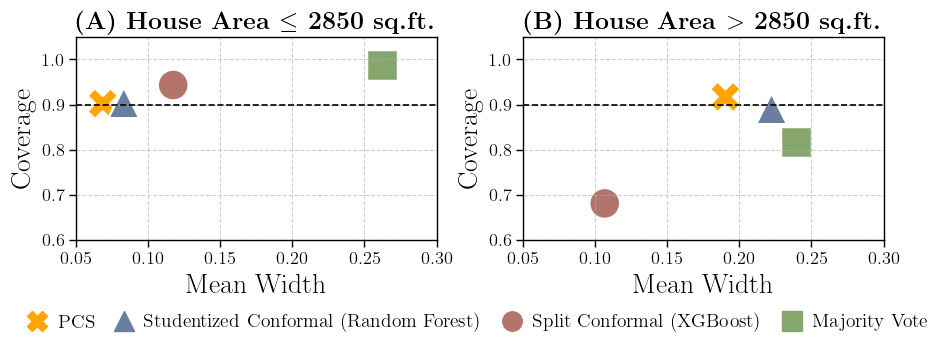

In [11]:
sgs = [r'(A) House Area $\leq$ 2850 sq.ft.', r'(B) House Area $>$ 2850 sq.ft.']
make_subgroup_plot_v3('data_miami_housing', 'TOT_LVG_AREA', sgs, selected_methods,
                      xlims=[0.05, 0.3], ylims=[0.6, 1.05],
                      save_path='figures/subgroup_miami.pdf')

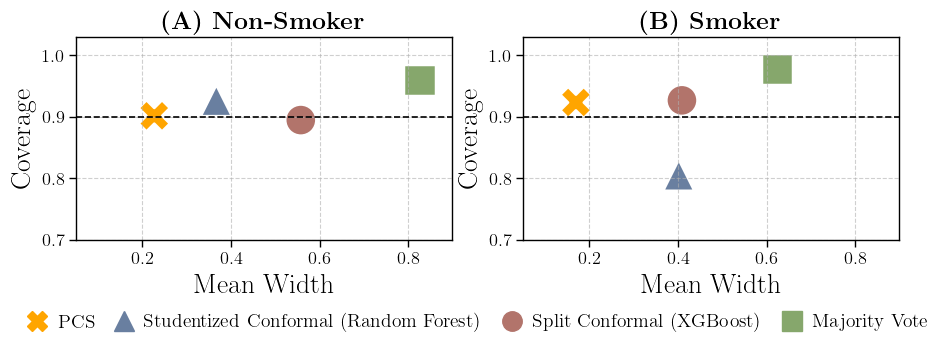

In [12]:
sgs = [r'(A) Non-Smoker', r'(B) Smoker']
make_subgroup_plot_v3('data_insurance', 'smoker_yes', sgs, selected_methods,
                   xlims=[0.05,0.9], ylims=[0.7, 1.03],
                   save_path='figures/subgroup_insurance.pdf')

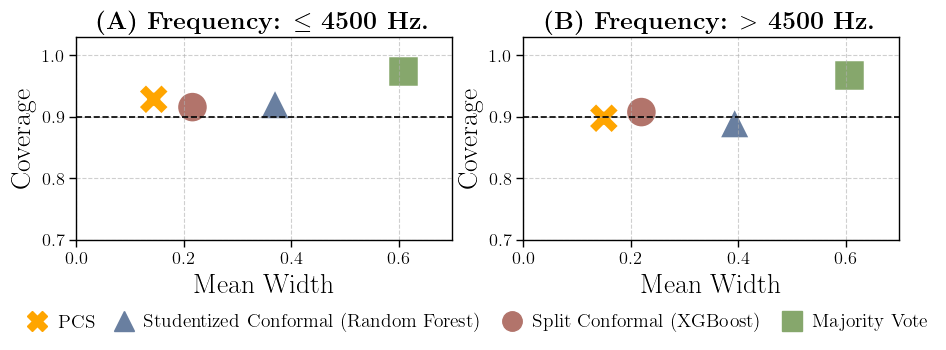

In [13]:
sgs = [r'(A) Frequency: $\leq$ 4500 Hz.', r'(B) Frequency: $>$ 4500 Hz.']
make_subgroup_plot_v3('data_airfoil', 'frequency', sgs, selected_methods,
                   xlims=[0, 0.7], ylims=[0.7, 1.03],
                   save_path='figures/subgroup_airfoil.pdf')

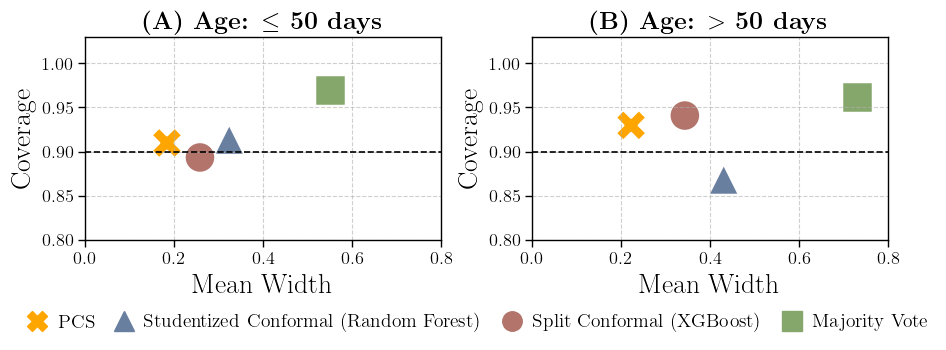

In [14]:
sgs = [r'(A) Age: $\leq$ 50 days', r'(B) Age: $>$ 50 days']
make_subgroup_plot_v3('data_concrete', 'Age', sgs, selected_methods,
                    xlims=[0, 0.8], ylims=[0.8, 1.03],
                    save_path='figures/subgroup_concrete.pdf')

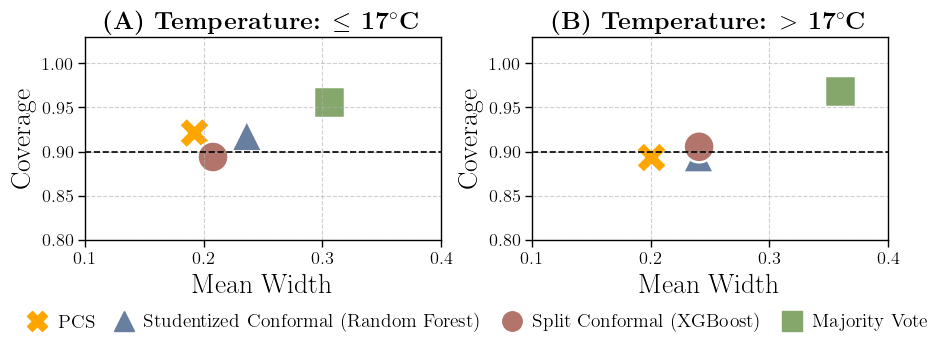

In [15]:
sgs = [r'(A) Temperature: $\leq$ 17$^\circ$C', r'(B) Temperature: $>$ 17$^\circ$C']
make_subgroup_plot_v3('data_powerplant', 'AT', sgs, selected_methods,
                    xlims=[0.1, 0.4], ylims=[0.8, 1.03],
                    save_path='figures/subgroup_powerplant.pdf')

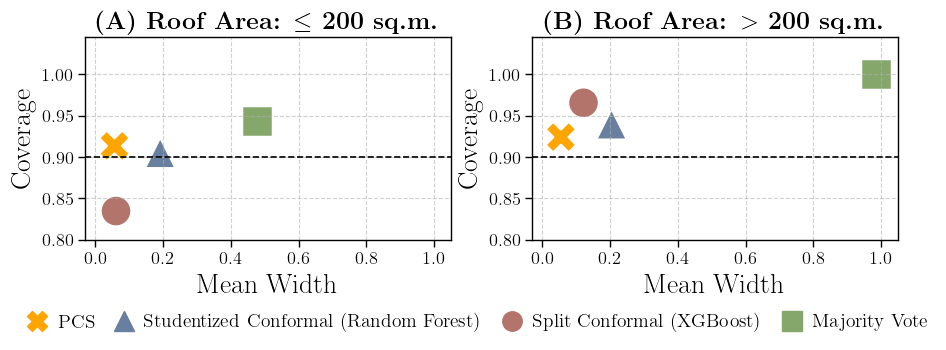

In [16]:
sgs = [r'(A) Roof Area: $\leq$ 200 sq.m.', r'(B) Roof Area: $>$ 200 sq.m.']
make_subgroup_plot_v3('data_energy_efficiency', 'Roof_Area', sgs, selected_methods,
                   xlims=[-0.03, 1.05], ylims=[0.8, 1.045],
                   save_path='figures/subgroup_energy_efficiency.pdf')

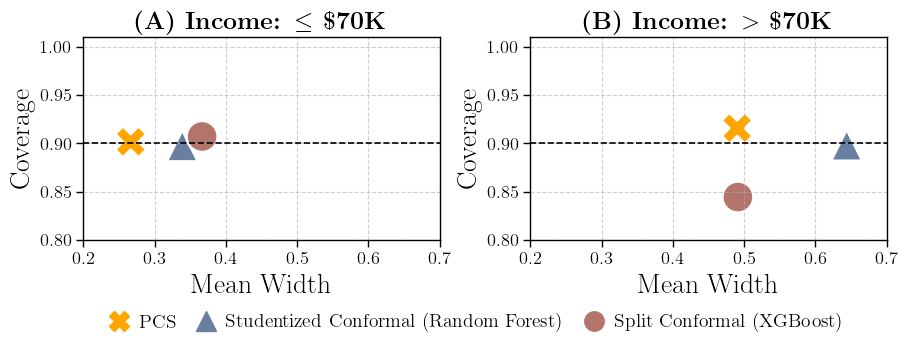

In [17]:
selected_methods = [('pcs_oob',''), ('studentized_conformal', 'RandomForest'), ('split_conformal', 'XGBoost'), ]
sgs = [r'(A) Income: $\leq$ \$70K', r'(B) Income: $>$ \$70K']
make_subgroup_plot_v3('data_ca_housing', 'med_income', sgs, selected_methods,
                   xlims=[0.2,0.7], ylims=[0.8,1.01], sg_select=[0,1],
                   save_path='figures/subgroup_ca.pdf')